**Instituto Tecnológico de Aeronáutica – ITA**

**Inteligência Artificial para Robótica Móvel – CT-213**

**Professores:** 

Marcos Ricardo Omena de Albuquerque Maximo

André Oliveira Françani


# Laboratório 8 – Redes Neurais Convolucionais

# 1. Introdução
 
Nesse laboratório, seu objetivo é implementar, treinar e testar a rede neural LeNet-5 usando o dataset MNIST.  O MNIST consiste num conjunto grande de imagens anotadas de dígitos decimais escritos à mão. Assim, você reproduzirá um trabalho clássico da Literatura de Redes Neurais Convolucionais (CNNs), que foi realizado originalmente por Yann LeCun. A Figura 1 apresenta uma das imagens do MNIST juntamente com o *label* esperado (de acordo com a anotação) e o *label* predito pela LeNet-5.

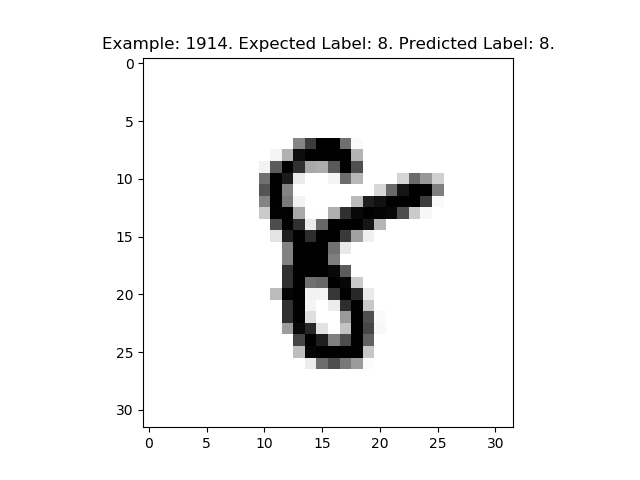

**Figura 1**: exemplo de dígito escrito à mão do *dataset* MNIST.


# 2. Descrição do Problema

O problema a ser resolvido nesse laboratório é implementar, treinar e testar a rede LeNet-5 no *dataset* MNIST. Para isso, você deve usar a *framework* Keras com *backend* Tensorflow. A Tabela 1 apresenta uma descrição da rede LeNet-5. A entrada da rede é (32, 32, 1), em que os números representam largura, altura e número de canais de cor da imagem, respectivamente. Para ajuda em como implementar cada uma dessas camadas usando Keras, recomenda-se verificar a Seção 6 (Dicas). Além disso, destaca-se que o aluno pode encontrar algumas interpretações mais modernas da LeNet-5 na Internet, mas pede-se para implementar a arquitetura dessa rede conforme descrito na Tabela 1.


|**Camada**|**Tipo**|**Número de Filtros**|**Tamanho da Saída**|**Tamanho do Kernel**|***Stride***|***Activation Function***|
|:------|:----------------|:--|:----|:---|:-|:------|
|Entrada|Imagem           |1  |32x32|-   |- |-      |
|1      |Conv2D           |6  |28x28|5x5 |1 |tanh   |
|2      |AveragePooling2D |6  |14x14|2x2 |2 |-      |
|3      |Conv2D           |16 |10x10|5x5 |1 |tanh   |
|4      |AveragePooling2D |16 |5x5  |2x2 |2 |-      |
|5      |Conv2D           |120|1x1  |5x5 |1 |tanh   |
|6      |*Dense* (FC)     |-  |84   |-   |- |tanh   |
|7      |*Dense* (FC)     |-  |10   |-   |- |softmax|

<p align="center">
<b>Tabela 1</b>: arquitetura da LeNet-5. </p>

# 3. Código Base

O código base fornece diversas implementações para facilitar o uso do NMIST e o treinamento e avaliação da LeNet-5. Você precisa apenas editar a Seção 4.3, onde deve ser implementada a LeNet-5.


# 4. Tarefas

Comece o laboratório executando a célula abaixo com algumas funções auxiliares. As funções são utilizadas para ler a base de dados MNIST, visualizar uma imagem, salvar o modelo treinado e carregar um modelo já treinado. **Não há necessidade de alterá-las**.

In [45]:
import gzip
import numpy as np
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt


def read_mnist(images_path, labels_path):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
            .reshape(length, 784) \
            .reshape(length, 28, 28, 1)

    # Pad images with 0s
    features = np.pad(features, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

    return features, labels


def display_image(image, title):
    image = image.squeeze()
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=plt.cm.gray_r)


def save_model_to_json(model, model_name):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + '.json', 'w') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + '.h5')


def load_model_from_json(model_name):
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_name + '.h5')
    return loaded_model

## 4.1.	*Download* do NMIST

Execute a célula abaixo para fazer o *download* do MNIST. 4 arquivos devem ser baixados:

- train-images-idx3-ubyte.gz:  *training set images* (9912422 *bytes*).
- train-labels-idx1-ubyte.gz:  *training set labels* (28881 *bytes*).
- t10k-images-idx3-ubyte.gz:   *test set images* (1648877 *bytes*).
- t10k-labels-idx1-ubyte.gz:   *test set labels* (4542 *bytes*).


In [46]:
from requests import get


def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## 4.2.	Exploração do NMIST

Execute o a célula abaixo para explorar o NMIST. Alguns dados sobre o *training* e *test sets* serão mostradas. Além disso, são mostradas algumas imagens aleatórias. **Não há necessidade de incluir essas imagens no seu relatório**.


# of training images: 60000
# of test images: 10000


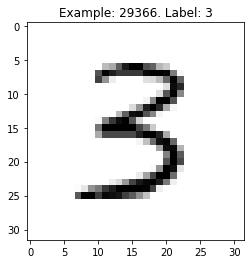

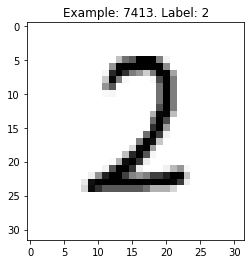

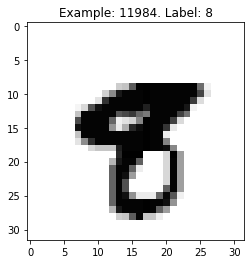

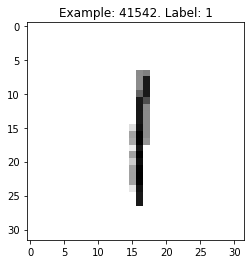

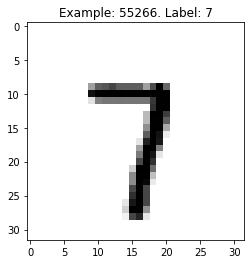

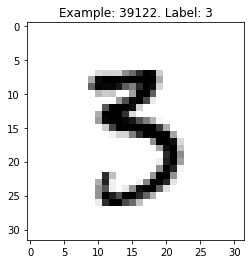

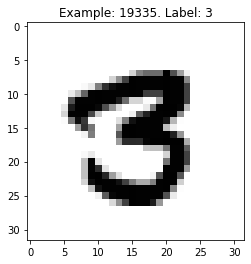

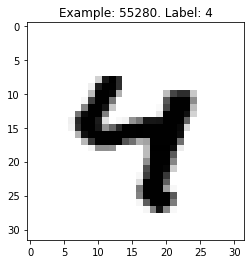

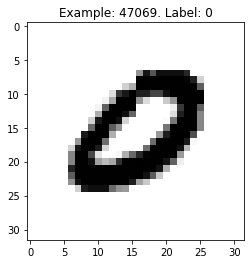

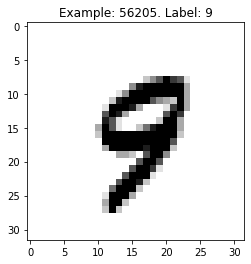

In [47]:
import random
import matplotlib.pyplot as plt


NUM_IMAGES = 10

train_features, train_labels = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_features, test_labels = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

print('# of training images:', train_features.shape[0])
print('# of test images:', test_features.shape[0])

for i in range(NUM_IMAGES):
    index = random.randint(0, train_features.shape[0])
    display_image(train_features[index], 'Example: %d. Label: %d' % (index, train_labels[index]))

plt.show()

## 4.3. Implementação da LeNet-5

Usando Keras, implemente a arquitetura LeNet-5 de acordo com a arquitetura apresentada na Tabela 1. Há dicas na Seção 6 para te ajudar. **Observações**:

- Não há necessidade de se preocupar com regularização ou normalização para o correto treinamento da rede.

- A implementação da LeNet-5 é muito simples usando Keras. Serão poucas linhas de código.

- Como essa é uma rede muito clássica, há diversos lugares na *Internet* com implementações dela. Porém, recomendo que você tente implementar você mesmo a rede ao invés de procurar código já pronto. Além disso, perceba que a rede deve ser implementada exatamente conforme mostrado na Tabela 1.


In [48]:
from tensorflow.keras import layers, activations
from tensorflow.keras.models import Sequential


def make_lenet5():
    model = Sequential()
    
    model.add(layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation=activations.tanh, input_shape=(32,32,1)))
    model.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation=activations.tanh))
    model.add(layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(filters=120, kernel_size=(5,5), strides=(1,1), activation=activations.tanh))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=84, activation=activations.tanh))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units=10, activation=activations.softmax))

    return model

## 4.4. Treinamento da LeNet-5

Treine a LeNet-5 implementada. Leia o código fornecido e tente entender o que está sendo feito. Perceba que a implementação separa o *training set* original, deixando algumas imagens para um *(cross-)validation set*.

Para verificar o treinamento da rede, você deve executar o Tensorboard **antes de iniciar o treinamento**. Em seguida, execute a célula de treinamento da rede, atualize a interface do TensorBoard clicando na setinha no canto superior direito (🔁). Para visualizar os novos pontos salvos no *log* do treinamento, vá atualizando a interface ao fim de cada *epoch*.  

Coloque imagens do Tensorboard mostrando a evolução do treinamento no seu relatório (pode tirar *print screen* dos gráficos do Tensorboard). Discuta os resultados obtidos.


In [49]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [50]:
tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 8800), started 0:38:43 ago. (Use '!kill 8800' to kill it.)

### Treinamento da LeNet-5


In [51]:
import os
from time import time

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard


# Comment this line to enable training using your GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

EPOCHS = 10
BATCH_SIZE = 128

# Load and split data
train_features, train_labels = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')

train_features, validation_features, train_labels, validation_labels = \
    train_test_split(train_features, train_labels, test_size=0.2, random_state=0)

print('# of training images:', train_features.shape[0])
print('# of cross-validation images:', validation_features.shape[0])

# Pre-processing data and build generator
X_train, y_train = train_features, to_categorical(train_labels)
X_validation, y_validation = validation_features, to_categorical(validation_labels)

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

# Build and compile model
model = make_lenet5()
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_validation.shape[0] // BATCH_SIZE

# Start training
tensorboard = TensorBoard(log_dir=os.path.join("logs", "{}".format(time())))
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True, callbacks=[tensorboard])

save_model_to_json(model, 'lenet5')

# of training images: 48000
# of cross-validation images: 12000
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_20 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_21 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_10 (Flatten)         (None, 120)               0         
_______________________________________________________

## 4.5. Avaliação da LeNet-5

Avalie a LeNet-5 no *test set* executando a célula abaixo. Além de exibir alguns exemplos aleatórios, incluindo o *label* anotado e o *label* predito pela LeNet-5, a implementação mostra alguns exemplos em que a rede errou a classificação. Inclua pelo menos um gráfico em que a predição da rede funcionou e outro em que ela errou a classificação no seu relatório. Comente os resultados obtidos.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_20 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_21 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_10 (Flatten)         (None, 120)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 84)              

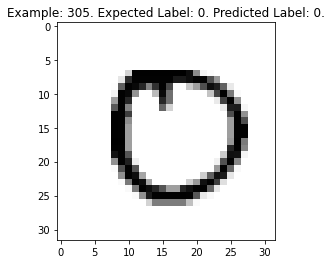

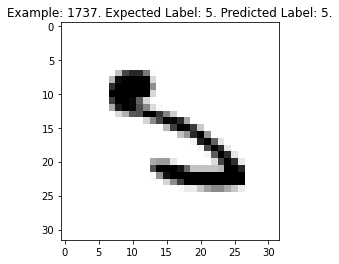

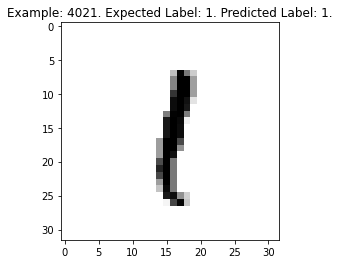

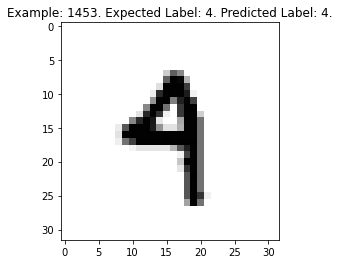

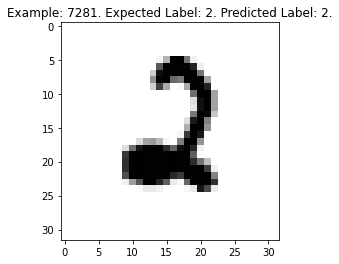

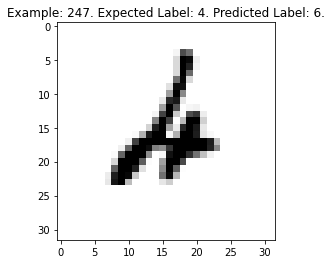

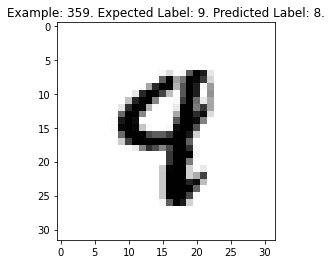

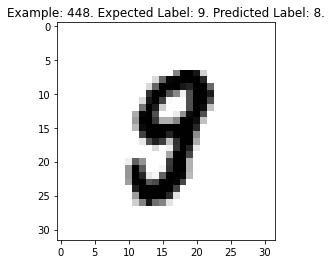

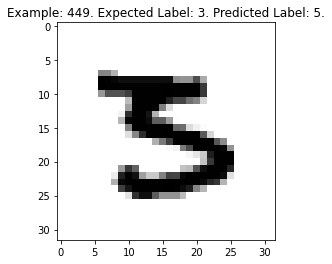

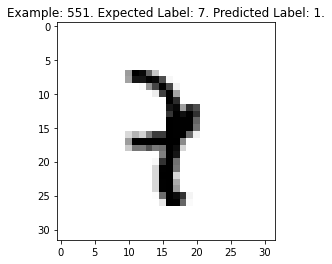

In [52]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential


# make results folder to save images
if not os.path.exists('results'):
  os.makedirs('results')

NUM_IMAGES_RANDOM = 5
NUM_IMAGES_MISCLASSIFICATION = 5

test_features, test_labels = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

model = load_model_from_json('lenet5')
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

predicted_labels = model.predict(test_features)
score = model.evaluate(test_features, to_categorical(test_labels))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

for i in range(NUM_IMAGES_RANDOM):
    index = random.randint(0, test_features.shape[0])
    display_image(test_features[index],
                  'Example: %d. Expected Label: %d. Predicted Label: %d.' %
                  (index, test_labels[index], np.argmax(predicted_labels[index, :])))
    plt.savefig('results/test_image_%d.png' % index, format='png')


count = 0
for i in range(test_features.shape[0]):
    if count == NUM_IMAGES_MISCLASSIFICATION:
        break
    if np.argmax(predicted_labels[i, :]) != test_labels[i]:
        display_image(test_features[i],
                      'Example: %d. Expected Label: %d. Predicted Label: %d.' %
                      (i, test_labels[i], np.argmax(predicted_labels[i, :])))
        plt.savefig('results/misclassified_image_%d.png' % i, format='png')
        count += 1

plt.show()

# 5. Entrega

A entrega consiste do notebook no formato **.ipynb** e de um relatório, submetida através do Google Classroom. Modificações nos arquivos do código base são permitidas, desde que o nome e a interface dos scripts “main” não sejam alterados. A princípio, não há limitação de número de páginas para o relatório, mas pede-se que seja sucinto. O relatório deve conter:

- Breve descrição em alto nível da sua implementação.
- Figuras que comprovem o funcionamento do seu código.

Por limitações do Google Classroom (e por motivo de facilitar a automatização da correção), entregue seu laboratório com todos os arquivos num único arquivo **.zip** (**não** utilize outras tecnologias de compactação de arquivos) com o seguinte padrão de nome: **“<login_email_google_education>_labX.zip”**. Por exemplo, no meu caso, meu login Google Education é **marcos.maximo**, logo eu entregaria o lab 8 como **“marcos.maximo_lab8.zip”**. **Não** crie subpastas para os arquivos da sua entrega, **deixe todos os arquivos na “raiz” do .zip**. Os relatórios devem ser entregues em formato **.pdf**.

# 6. Dicas

- Para criar uma camada de convolução 2D no Keras, faça:
```python 
model.add(layers.Conv2D(filters=nf, kernel_size=(fx, fy), strides=(sx, sy), activation=activations.fun))
```
em que nf, fx, fy, sx, sy e fun configuram a camada.

- Para a primeira camada, também é importante definir o formato da entrada como um tensor de (32, 32, 1) (imagem de 32x32 e 1 canal de cor):
```python
model.add(layers.Conv2D(filters=nf, kernel_size=(fx, fy), strides=(sx, sy), activation=activations.fun, input_shape=(32, 32, 1)))
```

- Para criar uma camada de *average pooling* no Keras, faça:
```python
model.add(layers.AveragePooling2D(pool_size=(px, py), strides=(sx, sy)))
```
em que px, py, sx e sy configuram a camada.

- Para definir a camada de transição entre as camadas convolucionais e as densas (completamente conectadas), a qual é a camada 5 na LeNet-5, faça o seguinte:
```python
model.add(layers.Flatten())
model.add(layers.Dense(units=num_neurons, activation=activations.fun))
```

- Para fazer o download das figuras e usá-las no relatório, use os seguintes comandos:
```python
from google.colab import files
import os
os.system('zip -r lab8_results.zip results')
files.download("lab8_results.zip")
```

- Você pode também fazer o download dos logs, do modelo lenet5.json e dos pesos lenet5.h5 se quiser guardá-los.